In [1]:
import keras
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Activation, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D    
from random import randint

Using TensorFlow backend.


In [2]:
debug = True

In [3]:
path = 'data/driving_log.csv'

In [4]:
def import_data(csv_file):
    images, steering = [], []
    with open(csv_file) as csvfile:
        reader = csv.DictReader(csvfile)
        degrees = 10
        correction = degrees *0.01
        for row in reader:
            steering_value = float(row['steering'])
            images.append(row['center'])
            steering.append(steering_value)
            
            if (steering_value > 0.1 or steering_value < -0.1):
                # adding left camera images
                images.append(row['left'].strip())
                steering.append(steering_value + correction)
                # adding right camera images
                images.append(row['right'].strip())
                steering.append(steering_value - correction)
                
    return images, steering
   
def convert_path_to_images(images_raw, measurement):
    images = []
    measurements = []

    for i in range(len(images_raw)):
        measurements.append(measurement[i])
        images.append(cv2.imread("data/" + images_raw[i]))
    
    return images, measurements

def flip_images(images, measurements):
    augmented_images, augmented_measurements = [], []
    flipped_images, flipped_measurements = [], []

    for image, measurement in zip(images, measurements):
        augmented_images.append(image)
        augmented_measurements.append(measurement)

    for image, measurement in zip(images, measurements):
        flipped_images.append(cv2.flip(image, 1))
        flipped_measurements.append(measurement * -1.0)

    for i in range(int(len(flipped_measurements)/2)):
        random_int = randint(0, len(flipped_measurements) - 1)
        augmented_images.append(flipped_images[random_int])
        augmented_measurements.append(flipped_measurements[random_int])
    
    x_train = np.array(augmented_images)
    y_train = np.array(augmented_measurements)
    
    return x_train, y_train



In [5]:
def import_and_preprocess_images(csv_path):
    imported_images_paths, imported_measurements = import_data(csv_path)
    raw_images, steering_measurements = convert_path_to_images(imported_images_paths, imported_measurements)
    x_train, y_train = flip_images(raw_images, steering_measurements)
    return x_train, y_train


In [6]:
def get_data_information(x_train, y_train):
    print("Total training images: " + str(len(x_train)))
    print("Total training steering measurements: " + str(len(y_train)))
    print("Training image size: " + str(x_train[0].shape))
    
    print("Plotting data into histogram...")
    plt.hist(y_train, bins=20)
    plt.title("Steering Angles Distribution")
    plt.xlabel("Angle")
    plt.ylabel("Frequency")
    plt.show()
          
    print("Showing random example image and steering data...")
    random_int = randint(0, len(y_train) - 1)
    plt.imshow(x_train[random_int])
    plt.title("Steering angle: " + str(y_train[random_int]))
    plt.show()

In [7]:
x_train, y_train = import_and_preprocess_images(path)

Total training images: 18393
Total training steering measurements: 18393
Training image size: (160, 320, 3)
Plotting data into histogram...


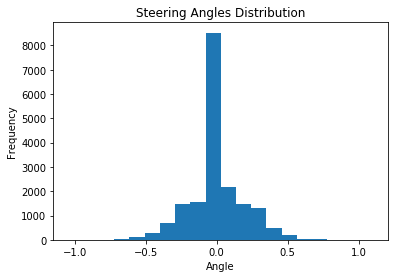

Showing random example image and steering data...


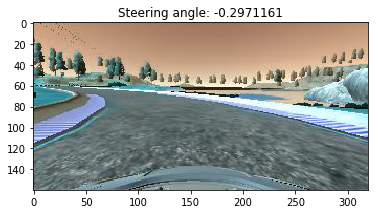

In [8]:
if debug:
    get_data_information(x_train, y_train)

In [9]:
def visualise_loss_data(history_object):
    ### print the keys contained in the history object
    print(history_object.history.keys())

    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

Starting convolutional processing...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 88, 318, 32)   896         cropping2d_1[0][0]               
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 44, 159, 32)   0           convolution2d_1[0][0]            
______________________________________________________

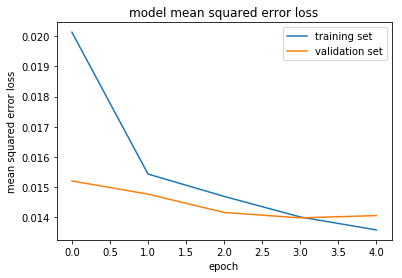

Saving data into model.h5
Model saved!


In [10]:
print('Starting convolutional processing...')

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (160, 320, 3)))
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))

model.add(Convolution2D(32,3,3, activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Convolution2D(32,3,3, activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Convolution2D(64,3,3, activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))

model.summary()

model.compile(loss = 'mse', optimizer = 'adam')
history_object = model.fit(x_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 5)

visualise_loss_data(history_object)

print("Saving data into model.h5")
model.save('model.h5')
print("Model saved!")
